## Code to enable dataset download from kaggle

In [ ]:
# configuring kaggle dataset downloading
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Dataset download and exploration

In [ ]:
!kaggle datasets download -d vin1234/count-the-number-of-faces-present-in-an-image
!mv count-the-number-of-faces-present-in-an-image.zip data.zip

100% 380M/381M [00:19<00:00, 23.5MB/s]
100% 381M/381M [00:19<00:00, 20.0MB/s]


In [ ]:
import zipfile
zip_file_name = 'data.zip'
dir = './'
zip_ref = zipfile.ZipFile(zip_file_name, 'r')
zip_ref.extractall(dir)
zip_ref.close()
!rm data.zip

In [ ]:
import os
import pandas as pd

train_csv_file = pd.read_csv('train/train.csv', dtype=str)
train_bbox_file = pd.read_csv('train/bbox_train.csv', dtype=str)
test_csv_file = pd.read_csv('test.csv', dtype=str)
print('number of images:', len(os.listdir('train/image_data')), '\nnumber of training images:', len(train_csv_file), '\nnumber of testing images:', len(test_csv_file))

number of images: 8196 
number of training images: 5733 
number of testing images: 2463


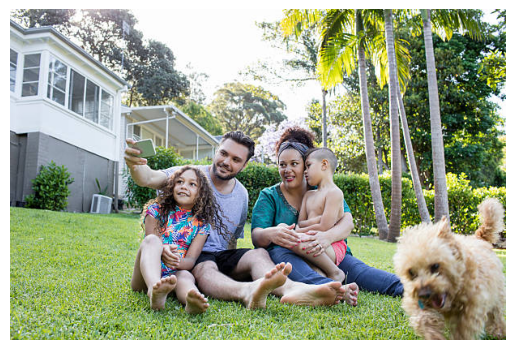

train/image_data/10001.jpg


In [ ]:
import matplotlib.pyplot as plt
for img_name in train_csv_file.Name:
  img_path = 'train/image_data/' + img_name
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print(img_path)
  break

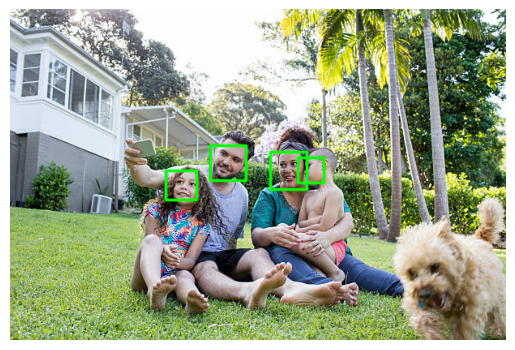

In [ ]:
import cv2
for index, row in train_bbox_file.iterrows():
    if row['Name'] == img_name:
        cv2.rectangle(img, [int(row['xmin']), int(row['ymin'])], [int(row['xmax']), int(row['ymax'])], color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(img)
plt.axis('off')
plt.show()

## Dataset formatting to YOLOv8 format

In [ ]:
from pathlib import Path

new_dataset_path = Path('dataset')
train_images_path = new_dataset_path/'train'/'images'
train_labels_path = new_dataset_path/'train'/'labels'
val_images_path = new_dataset_path/'val'/'images'
val_labels_path = new_dataset_path/'val'/'labels'
test_images_path = new_dataset_path/'test'/'images'

for path in [train_images_path, train_labels_path, val_images_path, val_labels_path, test_images_path]:
    if not path.is_dir():
        path.mkdir(parents=True, exist_ok=True)

In [ ]:
import os

old_dataset_path = Path('train/image_data')
all_images = os.listdir(old_dataset_path)
labeled_images = train_csv_file.Name.tolist()
print(len(all_images), len(labeled_images), len(all_images) - len(labeled_images))

8196 5733 2463


In [ ]:
train_csv_and_bbox = train_csv_file.merge(train_bbox_file, on='Name', how='left')
train_csv_and_bbox.head()

,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202


In [ ]:
import random
import shutil

train_len = int(0.8*len(labeled_images))
val_len = len(labeled_images) - train_len

train_images = random.sample(labeled_images, train_len)
for img_path in train_images:
    source_file = old_dataset_path/img_path
    if os.path.isfile(source_file):
        shutil.move(source_file, train_images_path)
    bboxes = train_csv_and_bbox[train_csv_and_bbox.Name==str(img_path)]
    label_file = img_path.split('.')[0]+'.txt'
    with open(train_labels_path/label_file, 'w') as file:
        i = 0
        for ind, row in bboxes.iterrows():
            xmin, xmax, ymin, ymax, width, height = int(row.xmin), int(row.xmax), int(row.ymin), int(row.ymax), int(row.width), int(row.height)
            x_center = ((xmin + xmax) / 2) / width
            y_center = ((ymin + ymax) / 2) / height
            width = (xmax - xmin) / width
            height = (ymax - ymin) / height
            i += 1
            if i==int(row.HeadCount):
                file.write(f"0 {x_center} {y_center} {width} {height}")
            else:
                file.write(f"0 {x_center} {y_center} {width} {height}\n")

val_images = [path for path in labeled_images if path not in train_images]
for img_path in val_images:
    source_file = old_dataset_path/img_path
    if os.path.isfile(source_file):
        shutil.move(source_file, val_images_path)
        bboxes = train_csv_and_bbox[train_csv_and_bbox.Name==str(img_path)]
        label_file = img_path.split('.')[0]+'.txt'
        with open(val_labels_path/label_file, 'w') as file:
            i = 0
            for ind, row in bboxes.iterrows():
                xmin, xmax, ymin, ymax, width, height = int(row.xmin), int(row.xmax), int(row.ymin), int(row.ymax), int(row.width), int(row.height)
                x_center = ((xmin + xmax) / 2) / width
                y_center = ((ymin + ymax) / 2) / height
                width = (xmax - xmin) / width
                height = (ymax - ymin) / height
                i += 1
                if i==int(row.HeadCount):
                    file.write(f"0 {x_center} {y_center} {width} {height}")
                else:
                    file.write(f"0 {x_center} {y_center} {width} {height}\n")

test_images = [el for el in all_images if el not in labeled_images]
for img_path in test_images:
    source_file = old_dataset_path/img_path
    if os.path.isfile(source_file):
        shutil.move(source_file, test_images_path)

print(len(os.listdir(train_images_path)), len(os.listdir(val_images_path)), len(os.listdir(test_images_path)))
shutil.rmtree('train')
shutil.rmtree('sample_data')

4586 1147 2463


### Creating data.yaml file

In [ ]:
try:
    import yaml
except:
    !pip install pyyaml
    import yaml

yaml_data = {
    'train': '../train/images',
    'val': '../val/images',
    'nc': 1,
    'names': ['face']
}
yaml_file_path = new_dataset_path / 'data.yaml'
with open(yaml_file_path, 'w') as file:
    yaml.dump(yaml_data, file, default_flow_style=None, sort_keys=False)

## Traning YOLOv8 nano model on our custom dataset

In [ ]:
HOME = os.getcwd()
print(HOME)
# !mkdir {HOME}/datasets
# shutil.move(new_dataset_path, f"{HOME}/datasets/")

/content


In [ ]:
!nvidia-smi

Sun Jan 21 04:10:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
try:
    import ultralytics
except:
    !pip install ultralytics
    import ultralytics
ultralytics.checks
from ultralytics import YOLO

# !yolo task=detect mode=train model=yolov8n.pt data='dataset/data.yaml' epochs=100 imgsz=400

model = YOLO('yolov8n.pt')
results = model.train(data='/content/dataset/data.yaml', epochs=20, imgsz=416)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.1/701.1 kB 10.6 MB/s eta 0:00:00


100%|██████████| 6.23M/6.23M [00:00<00:00, 122MB/s]


Ultralytics YOLOv8.1.3 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 28.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/dataset/train/labels... 4586 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4586/4586 [00:02<00:00, 1725.17it/s]


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/val/labels... 1147 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1147/1147 [00:01<00:00, 891.25it/s]


val: New cache created: /content/dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.18G      1.929      1.415      1.354         59        416: 100%|██████████| 287/287 [01:38<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:14<00:00,  2.55it/s]


                   all       1147       4943      0.928      0.817        0.9      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.16G      1.838       1.02      1.295         49        416: 100%|██████████| 287/287 [01:24<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.66it/s]


                   all       1147       4943       0.94      0.827      0.913      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.08G      1.801     0.9619      1.286         99        416: 100%|██████████| 287/287 [01:22<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.91it/s]

                   all       1147       4943      0.941      0.833      0.916       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.08G      1.786     0.9229      1.277         79        416: 100%|██████████| 287/287 [01:25<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.88it/s]

                   all       1147       4943      0.945      0.838      0.918      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.06G      1.775      0.885      1.278         82        416: 100%|██████████| 287/287 [01:23<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.23it/s]

                   all       1147       4943      0.951      0.842      0.927      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.15G      1.764     0.8668      1.276        110        416: 100%|██████████| 287/287 [01:25<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.97it/s]


                   all       1147       4943      0.947      0.852      0.926      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.14G       1.75     0.8507       1.27         58        416: 100%|██████████| 287/287 [01:24<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.89it/s]

                   all       1147       4943      0.953      0.871      0.944      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.21G      1.742     0.8412      1.272         66        416: 100%|██████████| 287/287 [01:25<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.23it/s]

                   all       1147       4943      0.949      0.863      0.939       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.13G      1.735     0.8223      1.259         63        416: 100%|██████████| 287/287 [01:23<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.85it/s]

                   all       1147       4943      0.943      0.869      0.939      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.14G      1.723     0.8039      1.259         94        416: 100%|██████████| 287/287 [01:25<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.94it/s]


                   all       1147       4943      0.955      0.877      0.948      0.473
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.21G      1.715     0.7516      1.296         34        416: 100%|██████████| 287/287 [01:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.67it/s]

                   all       1147       4943      0.953      0.883      0.947      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.14G      1.705     0.7365      1.291         33        416: 100%|██████████| 287/287 [01:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.04it/s]

                   all       1147       4943      0.958      0.883      0.949      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.13G      1.701     0.7183      1.285         40        416: 100%|██████████| 287/287 [01:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:13<00:00,  2.74it/s]

                   all       1147       4943      0.954      0.878      0.947      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.14G      1.694     0.7183      1.287         45        416: 100%|██████████| 287/287 [01:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.96it/s]

                   all       1147       4943       0.96       0.88      0.946      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.14G      1.678     0.6998      1.283         40        416: 100%|██████████| 287/287 [01:16<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]

                   all       1147       4943      0.959      0.887      0.952      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.14G      1.675     0.6878      1.274         54        416: 100%|██████████| 287/287 [01:16<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.87it/s]

                   all       1147       4943      0.961       0.89      0.957      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.06G      1.663     0.6753      1.275         45        416: 100%|██████████| 287/287 [01:17<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:14<00:00,  2.51it/s]

                   all       1147       4943      0.965      0.898      0.959      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.14G      1.649     0.6638      1.266         40        416: 100%|██████████| 287/287 [01:17<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.97it/s]

                   all       1147       4943       0.96      0.892      0.958      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.07G       1.65     0.6533      1.262         44        416: 100%|██████████| 287/287 [01:20<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:11<00:00,  3.04it/s]

                   all       1147       4943      0.965      0.899       0.96      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.07G       1.63     0.6411      1.254         36        416: 100%|██████████| 287/287 [01:17<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:12<00:00,  2.86it/s]

                   all       1147       4943      0.962      0.894       0.96      0.498



20 epochs completed in 0.530 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.3 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]


                   all       1147       4943      0.963      0.894      0.959      0.498
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


In [ ]:
!zip -r /content/runs.zip /content/runs/detect/train/

from google.colab import files
files.download('runs.zip')

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 3%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 8%)
  adding: content/runs/detect/train/P_curve.png (deflated 21%)
  adding: content/runs/detect/train/labels.jpg (deflated 29%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 39%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 4%)
  adding: content/runs/detect/train/train_batch2870.jpg (deflated 9%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 29%)
  adding: content/runs/detect/train/train_batch2871.jpg (deflated 13%)
  adding: content/runs/detect/train/results.png (deflated 6%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 9%)
  adding: content/runs/detect/train/events.out.tfevents.1705737768.afbfcef4c6b4.1087.0 (deflated 93%)
  adding: content/runs/detect/train/train_batch2872.jpg (deflated 8%)
  adding: content/runs/detect/t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Unzipping trained model results

In [ ]:
zip_file_name = 'runs.zip'
dir = './'
zip_ref = zipfile.ZipFile(zip_file_name, 'r')
zip_ref.extractall(dir)
zip_ref.close()
!rm runs.zip

### Examining model training results

(-0.5, 2999.5, 2249.5, -0.5)

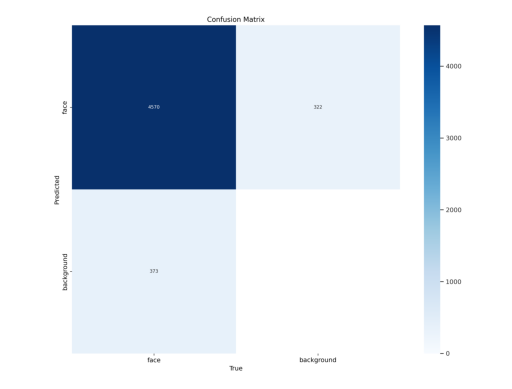

In [ ]:
plt.imshow(plt.imread('/content/runs/detect/train/confusion_matrix.png'))
plt.axis('off')

(-0.5, 2399.5, 1199.5, -0.5)

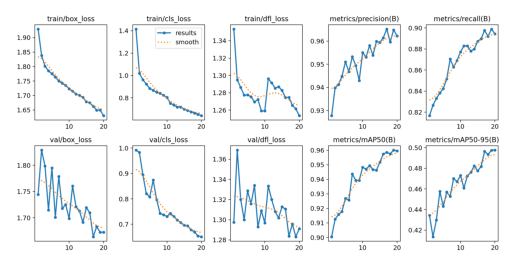

In [ ]:
plt.imshow(plt.imread('/content/runs/detect/train/results.png'))
plt.axis('off')

(-0.5, 1791.5, 1151.5, -0.5)

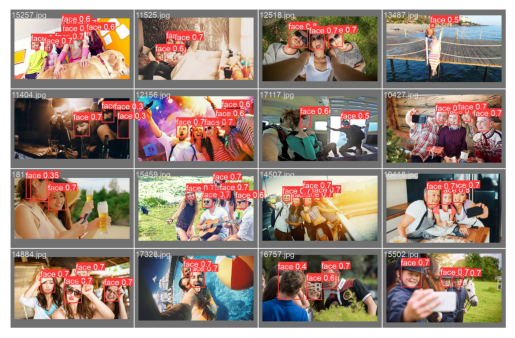

In [ ]:
plt.imshow(plt.imread('/content/runs/detect/train/val_batch0_pred.jpg'))
plt.axis('off')

## Model validation, prediction and evaluation

In [ ]:
# validation
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/dataset/data.yaml

Ultralytics YOLOv8.1.3 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
100% 755k/755k [00:00<00:00, 113MB/s]
val: Scanning /content/dataset/val/labels... 1147 images, 0 backgrounds, 0 corrupt: 100% 1147/1147 [00:00<00:00, 2047.47it/s]
val: New cache created: /content/dataset/val/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 72/72 [00:18<00:00,  3.92it/s]
                   all       1147       5057      0.965      0.916       0.97       0.52
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
# testing on all test images
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/dataset/test/images save=True

Ultralytics YOLOv8.1.3 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/2463 /content/dataset/test/images/10005.jpg: 288x416 3 faces, 96.6ms
image 2/2463 /content/dataset/test/images/10009.jpg: 288x416 3 faces, 9.6ms
image 3/2463 /content/dataset/test/images/10015.jpg: 288x416 4 faces, 8.9ms
image 4/2463 /content/dataset/test/images/10022.jpg: 288x416 4 faces, 7.7ms
image 5/2463 /content/dataset/test/images/10023.jpg: 288x416 4 faces, 9.4ms
image 6/2463 /content/dataset/test/images/10024.jpg: 288x416 5 faces, 10.4ms
image 7/2463 /content/dataset/test/images/10025.jpg: 288x416 5 faces, 7.8ms
image 8/2463 /content/dataset/test/images/10029.jpg: 288x416 5 faces, 9.4ms
image 9/2463 /content/dataset/test/images/10030.jpg: 288x416 5 faces, 8.2ms
image 10/2463 /content/dataset/test/images/10033.jpg: 288x416 4 faces, 8.3ms
image 11/2463 /content/dataset/test/images/10036.jpg: 288x416 4 faces, 

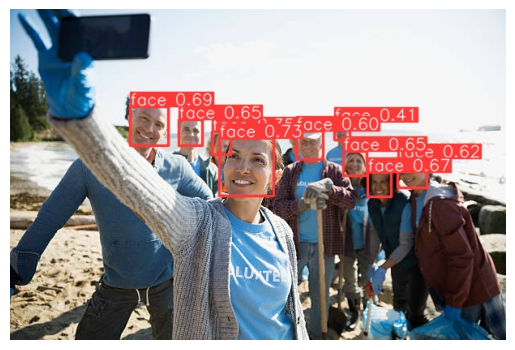

In [ ]:
# testing on a single image
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/dataset/test/images/10071.jpg save=True

predicted = plt.imread('runs/detect/predict/10071.jpg')
plt.imshow(predicted)
plt.axis('off')
plt.show()

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')
results = model.predict(source='/content/dataset/test/images/10033.jpg', conf=0.25)
print(f"Number of detected faces in the image: {len(results[0].boxes)}")
for ind, bbox in enumerate(results[0].boxes):
    print(f"BBox id: {ind}   xyxy: {bbox.xyxy}   confidence score: {bbox.conf}   class: {bbox.cls}")


WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dataset/test/images/10033.jpg: 288x416 4 faces, 104.6ms
Speed: 1.9ms preprocess, 104.6ms inference, 776.7ms postprocess per image at shape (1, 3, 288, 416)
Number of detected faces in the image: 4
BBox id: 0   xyxy: tensor([[211.4332,  72.4891, 288.8958, 149.5584]], device='cuda:0')   confidence score: tensor([0.7560], device='cuda:0')   class: tensor([0.], device='cuda:0')
BBox id: 1   xyxy: tensor([[248.7953, 157.2421, 328.9725, 236.6935]], device='cuda:0')   confidence score: tensor([0.7440], device='cuda:0')   class: tensor([0.], device='cuda:0')
BBox id: 2   xyxy: tensor([[332.0985, 138.5709, 402.3299, 209.1746]], device='cuda:0')   confidence score: tensor([0.7069], device='cuda:0')   class: tensor([0.], device='cuda:0')
BBox id: 3   xyxy: tensor([[403.8720, 115.9804, 478.4651, 188.2517]], device='cuda:0')   confidence score: tensor([0.5785], device='cuda:0')   class: tensor([0.], device='cuda:0')


### Counting faces in test images and writing to test.csv file

In [ ]:
test_csv_file['HeadCount'] = ''
for img in test_images:
    img_path = test_images_path/img
    results = model.predict(source=img_path, conf=0.4)
    num_faces = len(results[0].boxes)
    test_csv_file.loc[test_csv_file.Name==img, 'HeadCount'] = num_faces

Streaming output truncated to the last 5000 lines.
image 1/1 /content/dataset/test/images/16996.jpg: 416x288 5 faces, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 288)

image 1/1 /content/dataset/test/images/16412.jpg: 416x288 4 faces, 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 288)

image 1/1 /content/dataset/test/images/10628.jpg: 288x416 3 faces, 9.9ms
Speed: 1.5ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 416)

image 1/1 /content/dataset/test/images/11969.jpg: 288x416 2 faces, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 416)

image 1/1 /content/dataset/test/images/16007.jpg: 288x416 2 faces, 8.8ms
Speed: 1.3ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 416)

image 1/1 /content/dataset/test/images/16336.jpg: 288x416 4 faces, 10.4ms
Speed: 1.6ms preprocess, 

In [ ]:
test_csv_file.to_csv('test.csv', index=False)
test_csv_file.head()
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Testing model in video

In [ ]:
# !yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/video.mp4 save=True

model = YOLO('/content/runs/detect/train/weights/best.pt')
video_source = 'video.mp4'
video_results = model(video_source, stream=False, save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/2340) /content/video.mp4: 256x416 (no detections), 100.5ms
video 1/1 (2/2340) /content/video.mp4: 256x416 (no detections), 6.7ms
video 1/1 (3/2340) /content/video.mp4: 256x416 (no detections), 7.1ms
video 1/1 (4/2340) /content/video.mp4: 256x416 (no detections), 6.6ms
video 1/1 (5/2340) /content/video.mp4: 256x416 (no detections), 6.5ms
video 1/1 (6/2340) /content/video.mp4: 256x416 (no detections), 6.7ms
video 1/1 (7/2340) /content/video.